<a href="https://colab.research.google.com/github/qusaysellat/Python-Machine-Lerning-Tutorial/blob/master/Convolutional_Autoencoder_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**THIS IS A CONVOLUTIONAL AUTO-ENCODER FOR** *MNIST DATASET*

>NAME : [QUSAY SELLAT](https://github.com/qusaysellat)

>FOR MORE INFORMATION ABOUT 'MNIST' VISIT
[THIS SITE](http://yann.lecun.com/exdb/mnist/)

In [0]:
# first lets import used libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [0]:
# then import MNIST dataset
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('/tmp/data/', one_hot = True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use urllib or similar directly.
Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from t

In [0]:
# lets try to play with this data set

# lets see the dimensions of train, validation, and test datasets - note that mnist is a named tupple
print(mnist.train._images.shape)
print(mnist.train._labels.shape)
print(mnist[1]._images.shape)
print(mnist[1]._labels.shape)
print(getattr(mnist, 'test')._images.shape)
print(getattr(mnist, 'test')._labels.shape)

(55000, 784)
(55000, 10)
(5000, 784)
(5000, 10)
(10000, 784)
(10000, 10)


In [0]:
# lets take a sample of our data and discover its values
print('the first 8 labels in the training set:')
print(mnist[0]._labels[:8, : ])

the first 8 labels in the training set:
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


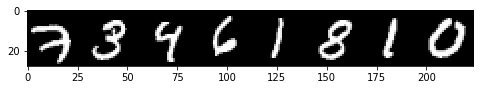

In [0]:
# now lets draw the sample we have just viewed

canvas = np.zeros((28, 28 * 8))
for i in range(8):
  canvas[:, 28 * i : 28 * (i + 1)] = mnist[0].images[i, :].reshape([28 ,28])
  
plt.figure(figsize = (8, 64))
plt.imshow(canvas, origin = 'upper', cmap ='gray')
plt.show()

In [0]:
# now we have to initialize important hyperparameters
LR = 0.001
steps = 7001
batch_size = 128 

In [0]:
# lets define parameters for network structure
I = 784
O = 10
dropout = 0.2

In [0]:
# lets define the function that encapsulates the forward propagation operations of our model
def forward_phase(x_dict, n_classes, dropout, reuse, is_training) :
  
  # first we have to ensure sharing the variables between training and testing phases
  with tf.variable_scope('CNN', reuse = reuse) :
    
    # extract the images from the input
    x = x_dict['images']
    
    # reshape images so that they can be passed to tf layers
    x = tf.reshape(x, [-1, 28, 28, 1])
    
    # lets start with encoder phase

    # first conv layer
    x = tf.layers.conv2d(x, 32, 5, padding='SAME', activation = tf.nn.relu)
    
    # first pooling layer
    x = tf.layers.max_pooling2d(x, 2, 2)
    
    # second conv layer
    x = tf.layers.conv2d(x, 64, 3, padding='SAME', activation = tf.nn.relu)
    
    # second pooling layer
    x = tf.layers.max_pooling2d(x, 2, 2)
    
    # flatten x to fit the dense layers
    x = tf.contrib.layers.flatten(x)
    
    # dense layer
    x = tf.layers.dense(x, 512)
    
    # perform dropout if training phase
    # x = tf.layers.dropout(x, rate = dropout, training = is_training)
    
    # this is the encoding
    x = tf.layers.dense(x, 64)

    # it's time to start with decoder phase

    # reverse of dense layer
    x = tf.layers.dense(x, 512)

    # reverse of flattened layer
    x = tf.layers.dense(x, 7*7*64)

    # unflatten x to fit the deconvolutional layers
    x = tf.reshape(x, shape=[-1, 7, 7, 64])

    # reverse of pooling layer
    x = tf.image.resize_bilinear(x, size=[14, 14], align_corners=None)

    # reverse of convolutional layer
    x = tf.contrib.layers.conv2d_transpose(x, kernel_size=3, padding='SAME', num_outputs=32, activation_fn=tf.nn.relu)

    # reverse of pooling layer
    x = tf.image.resize_bilinear(x, size=[28, 28], align_corners=None)

    # reverse of convolutional layer
    x = tf.contrib.layers.conv2d_transpose(x, kernel_size=5, padding='SAME', num_outputs=1, activation_fn=tf.nn.relu)

    # reshape images so that they return to input shape
    x = tf.reshape(x, [-1, 28*28])
  
  return x

In [0]:
# lets define our model that will be fed into the estimator
def model_fn(features, labels, mode) :
  
  # extract the logits
  output_train = forward_phase(features, O, dropout, reuse = False, is_training = True)
  output_test = forward_phase(features, O, dropout, reuse = True, is_training = False)
  
  # find predicted classes and prediction probabilities according to softmax
  # pred_classes = tf.arg_max(logits_test, 1)
  # pred_probs = tf.nn.softmax(logits_test)
  
  # if mode is PREDICT return the predicted classes
  if mode == tf.estimator.ModeKeys.PREDICT :
    return tf.estimator.EstimatorSpec(mode, output_test)
  
  # define loss function
  # loss_op = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(labels = tf.cast(labels, dtype = tf.int32), logits = logits_train))
  loss_op = tf.reduce_mean(tf.square(tf.subtract(features['images'], output_train)))

  # define optimizer function
  train_op = tf.train.AdamOptimizer(LR).minimize(loss_op, global_step = tf.train.get_global_step())
  
  # define accuracy function
  # accuracy_op = tf.metrics.accuracy(labels, pred_classes)
  
  if mode == tf.estimator.ModeKeys.EVAL :
    preds = output_test
  else :
    preds = output_train
    
  # return calculated functions
  return tf.estimator.EstimatorSpec(
      mode = mode, 
      predictions = preds,
      loss = loss_op,
      train_op = train_op,
      # eval_metric_ops = {'Accuracy' : accuracy_op}
  )
  

In [0]:
# build the model
model = tf.estimator.Estimator(model_fn)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/tmp/tmpems6uwrb', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fde96863400>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [0]:
# train the model

input_fn = tf.estimator.inputs.numpy_input_fn(
    x = {'images' : mnist.train.images}, 
    y = mnist.train.labels, 
    batch_size = batch_size, 
    num_epochs = None, 
    shuffle = True
)

model.train(input_fn = input_fn, steps = steps)


Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.
Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updat

In [0]:
# lets now test our trained model

# it would be better if we visualize the results

# number of examples per each row/column
n = 8

# we would like not to waste the space, lets define canvases for drawing
canvas1 = np.zeros((28*n, 28*n))
canvas2 = np.zeros((28*n, 28*n))

for i in range(n) :
  
  # get the next batch
  batch_x, batch_y = mnist.test.next_batch(n)
  
  # calculate the predicted values
  input_fn = tf.estimator.inputs.numpy_input_fn(
      x = {'images' : batch_x},
      shuffle = False
      )
  decoded_x = list(model.predict(input_fn))
  
  for j in range(n) :
     
      # draw the images of true labels
      canvas1[28 * i : 28 * (i + 1), 28 * j : 28 * (j + 1)] = batch_x[j].reshape([28, 28])
      
      # draw the images of predicted labels
      canvas2[28 * i : 28 * (i + 1), 28 * j : 28 * (j + 1)] = decoded_x[j].reshape([28, 28])

print('Original Digits:')      
plt.figure(figsize = (n, n))
plt.imshow(canvas1, origin = 'upper', cmap = 'gray')
plt.show()
  
print('Reconstructed Digits:')
plt.figure(figsize = (n, n))
plt.imshow(canvas2, origin = 'upper', cmap = 'gray')
plt.show()
  